In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [66]:
# nv = 3
# nh = 3
# n = nv + nh

nv = 97
nh = 97
n = nv + nh

In [56]:
learning_rate = 1e-7
epochs = 10
batch_size = 100
k = 3      


In [8]:
#basic test training
N = 10000
states = np.array([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])
idx = np.random.choice(np.arange(len(states)), N)
data = states[idx]
data = torch.from_numpy(data)
train_loader = torch.utils.data.DataLoader(dataset = data.to(torch.float), batch_size = batch_size, shuffle = True)


Shape of train and test datasets
torch.Size([500, 97, 1])
torch.Size([500, 3, 1])
torch.Size([100, 97, 1])
torch.Size([100, 3, 1])


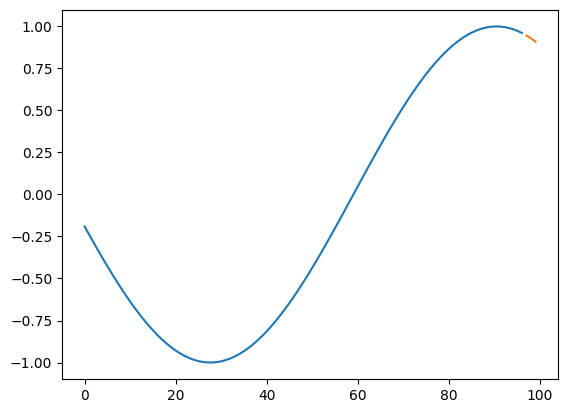

In [9]:
#real training
N = 10 # number of samples
L = 1000 # length of each sample (number of values for each sine wave)
T = 20 # width of the wave
x = np.empty((N,L), np.float32) # instantiate empty array
x[:] = np.arange(L) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)


wind_size = 100
y_windowed = []
x_wind = []
y_wind = []

for i in range(wind_size,L):
    curr = y[:,i-wind_size:i]
    res = np.swapaxes(curr,0,1)
    x_wind.append(res[0:97])
    y_wind.append(res[-3:])

x_wind = np.array(x_wind)[:,:,0:1]
y_wind = np.array(y_wind)[:,:,0:1]

x_train = torch.from_numpy(x_wind[0:500])
y_train = torch.from_numpy(y_wind[0:500])
x_test = torch.from_numpy(x_wind[800:])
y_test = torch.from_numpy(y_wind[800:])
print("Shape of train and test datasets")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
x_axis_test = np.arange(0,100)
plt.plot(x_axis_test[0:97],x_wind[5,:,0])
plt.plot(x_axis_test[-3:],y_wind[5,:,0])
plt.show()

In [10]:
x_train.reshape(500,97).shape
train_loader = torch.utils.data.DataLoader(dataset = x_train.reshape(500,97).to(torch.float), batch_size = 1, shuffle = False)

In [67]:
class RBM(torch.nn.Module):   
	def __init__(self, nv, nh):
		super(RBM, self).__init__() 
		self.w = torch.nn.Parameter(torch.randn(nv, nh) * 0.01)
		self.a = torch.nn.Parameter(torch.zeros(nv))
		self.b = torch.nn.Parameter(torch.zeros(nh))
		self.sigma_a = torch.ones(nv)    
		self.sigma_b = torch.ones(nh)

	def sample_h(self, v):
		# phv = torch.sigmoid(torch.matmul(v, self.w) + self.b)
		# h = torch.bernoulli(phv)
		# return h, phv
		h = torch.normal(mean=torch.matmul(v, self.w) + self.b,std=self.sigma_b)
		return h
	    
	def sample_v(self, h):
		# pvh = torch.sigmoid(torch.matmul(h, self.w.t()) + self.a)
		# v = torch.bernoulli(pvh)
		# return v, pvh
		v = torch.normal(mean=torch.matmul(h,self.w.T) + self.a,std=self.sigma_a)
		return v
	    
	def forward(self, v):
		h = self.sample_h(v)
		#gibbs sampling
		for i in range(k):	
			v = self.sample_v(h)
			h= self.sample_h(v)
			v= self.sample_v(h)
			return v
		
	def predict(self,v):
		h = self.sample_h(v)
		return(h)
	    
	def free_energy(self, v):
		# vt = torch.matmul(v, self.a)
		# ht = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.w) + self.b)), dim = 1)
		# return -(vt + ht)

		vt = torch.matmul(v,self.a)
		vvt = torch.matmul(v,v.T)*0.5
		aat = torch.matmul(self.a,self.a)*0.5
		hm = torch.sum(torch.log(1+torch.exp(torch.matmul(v,self.w)+self.b)))
		# ht = torch.sum(torch.log(1 + torch.exp(torch.matmul(v, self.w) + self.b)), dim = 1)
		return -vt +vvt + aat -hm

In [68]:
def train(rbm, train_loader, learning_rate, k, training_epochs,device="cpu"):
	optimizer = torch.optim.Adam(rbm.parameters(), lr=learning_rate)
	for epoch in range(training_epochs):
		epoch_cost = 0.
		for batch in train_loader:
			batch = batch.view(-1, nv).to(device)
			v = rbm.forward(batch.view(-1)).to(device)
			cost = torch.mean(rbm.free_energy(batch)) - torch.mean(rbm.free_energy(v))
			cost = cost.to(device)
			epoch_cost += cost.item()
			optimizer.zero_grad()
			cost.backward()
			optimizer.step()
			print('Epoch [{}/{}], cost: {:.4f}'.format(epoch+1, training_epochs, epoch_cost))

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RBM(nv, nh).to("cpu")
train(model, train_loader, learning_rate, k, epochs,"cpu")

Epoch [1/10], cost: -21.2741
Epoch [1/10], cost: -39.8835
Epoch [1/10], cost: -62.6400
Epoch [1/10], cost: -92.5171
Epoch [1/10], cost: -106.6122
Epoch [1/10], cost: -143.2028
Epoch [1/10], cost: -163.8917
Epoch [1/10], cost: -174.3280
Epoch [1/10], cost: -186.4510
Epoch [1/10], cost: -213.3636
Epoch [1/10], cost: -230.4185
Epoch [1/10], cost: -249.8013
Epoch [1/10], cost: -275.2862
Epoch [1/10], cost: -286.7086
Epoch [1/10], cost: -305.4482
Epoch [1/10], cost: -329.5334
Epoch [1/10], cost: -357.5400
Epoch [1/10], cost: -374.1980
Epoch [1/10], cost: -397.3252
Epoch [1/10], cost: -420.8746
Epoch [1/10], cost: -434.2793
Epoch [1/10], cost: -449.1925
Epoch [1/10], cost: -462.6856
Epoch [1/10], cost: -480.8116
Epoch [1/10], cost: -501.6044
Epoch [1/10], cost: -524.4157
Epoch [1/10], cost: -551.0073
Epoch [1/10], cost: -569.9709
Epoch [1/10], cost: -583.5192
Epoch [1/10], cost: -607.3755
Epoch [1/10], cost: -643.7221
Epoch [1/10], cost: -671.7368
Epoch [1/10], cost: -693.9530
Epoch [1/10], 

tensor([[ 0.1606,  0.9521,  1.0719, -1.5897, -0.6282, -1.2411,  1.4332, -1.8440,
         -1.1903,  0.0441,  0.9523, -0.6668, -0.6324,  1.2123, -0.5198, -0.3227,
         -1.5319, -0.4442, -1.4191,  1.4136,  0.1603,  1.5327,  1.5410, -0.8952,
         -0.4504,  0.2159, -1.0825,  1.0455,  0.0475,  0.5028,  0.0671,  0.0437,
          1.2073,  1.1332,  1.2310, -1.7846,  0.7888,  0.3953, -2.5875,  0.5433,
         -0.0822, -2.0848,  0.3021, -1.8948,  0.2151, -0.5322, -0.9764,  0.6748,
          0.1893,  1.2898,  0.6471, -1.0163,  1.6272, -1.0643, -0.8548,  2.9371,
         -1.2151, -0.4334,  0.9263,  0.3640, -0.7580,  0.5161, -0.8921,  0.9014,
         -1.5315,  0.1797,  0.0638, -1.2705, -0.1884,  2.5373, -0.0246, -0.3612,
          1.0262,  1.2910,  0.9844,  0.1606,  0.8382,  0.1144, -0.8069,  0.3909,
          0.0313, -0.0680, -0.8790, -0.0464, -0.5428, -0.0125, -0.7867, -0.9613,
          0.3850, -2.6027, -0.5654, -0.6082, -0.1534,  0.6600, -0.0077, -0.7522,
          0.6525]], device='

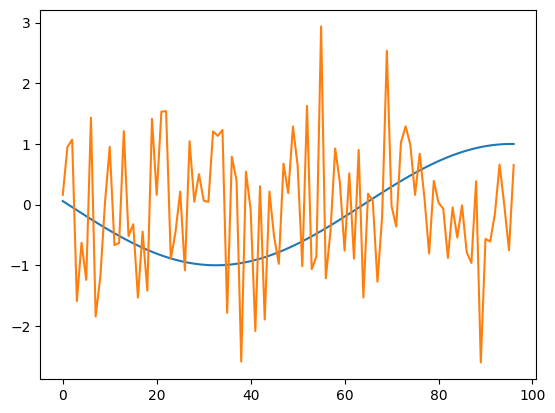

In [70]:
for batch in train_loader:  
    el = batch.numpy()[0]
    plt.plot(np.arange(el.shape[0]),el)

    v = model.predict(batch).to(device)
    s = v.cpu().detach().numpy()[0]
    plt.plot(np.arange(s.shape[0]),s)
    print(v)
    break